<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/C9IP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOAD

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
test_170 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0).reset_index(drop=True)

# 整理資料

In [3]:
test_200 = test_250.loc[ test_250.index % 5 != 0 ,:]#5不可整除
test_50 = test_250.loc[ test_250.index % 5 == 0 ,:]#5可以整除
train = train.append(test_200)#200筆加入train
print(train.shape)
print(test_170.shape)
print(test_50.shape)

(4721, 27)
(170, 27)
(50, 27)


# def features y_name

In [0]:
features = ['T10','T50','T90','N+A']
y_name = 'C9IP'

# features scaler

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train[features])

train[features] = scaler.transform(train[features])
test_170[features] = scaler.transform(test_170[features])
test_50[features] = scaler.transform(test_50[features])

# CORR WITH X

找找高相關特徵

In [6]:
corr_x = abs(train.iloc[:,:4].join(train[y_name]).corr()).loc[[y_name]].T.sort_values(by=y_name,ascending=False).T
corr_x

,C9IP,T50,T10,N+A,T90
C9IP,1.0,0.65164,0.634649,0.533834,0.25437


# CORR WITH Y

找找高相關y

In [7]:
corr_y = abs(train.iloc[:,4:].corr())[[y_name]].sort_values(by=y_name,ascending=False).T
corr_y

,C9IP,C8NP,C9NP,C8IP,C6N,C7NP,C6IP,C5NP,C5IP,C10IP,C9A,C5N,C7N,C7IP,C8N,C6A,C6NP,C7A,C8A,C9N,C10A,C10N,C10NP
C9IP,1.0,0.888828,0.881956,0.823955,0.806291,0.797645,0.765319,0.740485,0.730607,0.66422,0.631929,0.592493,0.592481,0.422237,0.392798,0.369814,0.363449,0.316158,0.276271,0.217092,0.184332,0.058966,0.032782


# 特徵萃取

In [0]:
from sklearn.manifold import isomap
iso_col = ['T50','N+A']
iso = isomap.Isomap(n_components=1).fit(train[iso_col])
#轉換
train['iso_x'] = iso.transform(train[iso_col])
test_170['iso_x'] = iso.transform(test_170[iso_col])
test_50['iso_x'] = iso.transform(test_50[iso_col])

# 檢查相關性

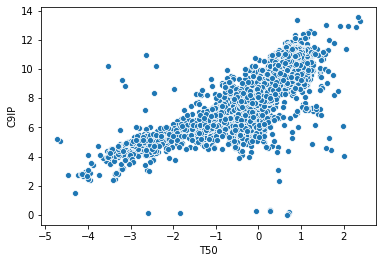

,T50,C9IP
T50,1.000000,0.813202
C9IP,0.813202,1.000000


In [9]:
sns.scatterplot(x='T50',y=y_name,data=train)
plt.show()
train.corr().loc[['T50',y_name],['T50',y_name]]

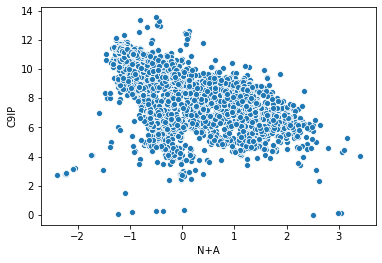

,N+A,C9IP
N+A,1.0000,-0.6552
C9IP,-0.6552,1.0000


In [10]:
sns.scatterplot(x='N+A',y=y_name,data=train)
plt.show()
train.corr().loc[['N+A',y_name],['N+A',y_name]]

這裡希望看到是漂亮的線性相關

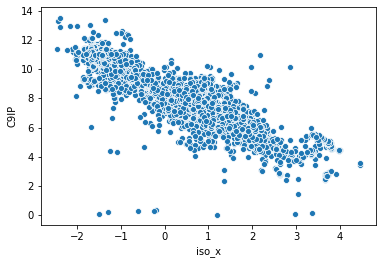

,iso_x,C9IP
iso_x,1.000000,-0.897387
C9IP,-0.897387,1.000000


In [11]:
sns.scatterplot(x='iso_x',y=y_name,data=train)
plt.show()
train.corr().loc[['iso_x',y_name],['iso_x',y_name]]

In [12]:
train[features+[y_name]+['iso_x']].corr().loc[[y_name]]

,T10,T50,T90,N+A,C9IP,iso_x
C9IP,0.787824,0.813202,0.29771,-0.6552,1.0,-0.897387


# modeling

評分指標

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p,name):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

In [14]:
import xgboost
from sklearn.svm import SVR
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import warnings 
warnings.simplefilter('ignore')

#選擇模型
#model = DecisionTreeRegressor(max_depth=1)
#model = xgboost.XGBRegressor(objective='reg:squarederror')
#model = SVR()
model = LinearRegression()

#交叉驗證
val_scores = cross_validate(model,train[['iso_x']],train[y_name],cv=5)

#交叉驗證結果
print('交叉驗證分數:',val_scores['test_score'])
print('交叉驗證平均分數:',val_scores['test_score'].mean())

交叉驗證分數: [0.86920039 0.65801824 0.81753512 0.68414047 0.81093233]
交叉驗證平均分數: 0.7679653084281124


# fit & predict

In [0]:
# fit 
model.fit(train[['iso_x']],train[y_name])
# predict
train['y_pred'] = model.predict(train[['iso_x']])
test_170['y_pred'] = model.predict(test_170[['iso_x']])
test_50['y_pred'] = model.predict(test_50[['iso_x']])

# plot

data for plot

In [0]:
by_col = 'iso_x'
train_sample_point = train.sample(1000).sort_values(by = by_col)
test_170_point = test_170.sort_values(by = by_col)
test_50_point = test_50.sort_values(by = by_col)

plot function

In [0]:
def pred_plot(df,by_col,name):
  plt.plot(df[by_col],df['y_pred'],label = name+'_pred',color='red')
  plt.scatter(df[by_col],df[y_name],label= name+'_data')

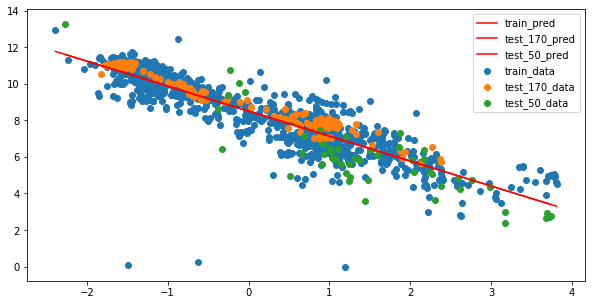

,R2,RMSE,mean_absolute_error
train,0.805304,0.894278,0.628800
test_170,0.910806,0.472326,0.407435
test_50,0.647693,1.233150,0.995775


In [18]:
fig = plt.figure(figsize=(10,5))
pred_plot(train_sample_point,by_col,'train')
pred_plot(test_170_point,by_col,'test_170')
pred_plot(test_50_point,by_col,'test_50')
plt.legend()
plt.show()
metric(train[y_name],train['y_pred'],'train').append(
    metric(test_170[y_name],test_170['y_pred'],'test_170')).append(
        metric(test_50[y_name],test_50['y_pred'],'test_50'))

# check outliers

In [19]:
loss = ((test_170_point[y_name] - test_170_point['y_pred'])**2).sort_values(ascending=False)
test_170_point['out'] = False
test_170_point.loc[loss.head(5).index,'out'] = True
print(loss.head(5))

153    1.231564
55     1.208897
52     1.064188
58     0.920769
57     0.862528
dtype: float64


In [20]:
loss = ((test_50_point[y_name] - test_50_point['y_pred'])**2).sort_values(ascending=False)
test_50_point['out'] = False
test_50_point.loc[loss.head(5).index,'out'] = True
print(loss.head(5))

95     8.887147
135    8.279337
145    6.465112
130    4.520910
60     3.705142
dtype: float64


# plot out

In [0]:
def d_out_score(df,name):
  df = df.loc[df['out'] == False]
  return metric(df[y_name],df['y_pred'],name)

In [0]:
def plot_out(df):
  fig = plt.figure(figsize=(10,5))
  out_point = df[df['out'] == True]
  plt.plot(df[by_col],df['y_pred'],label='pred line',color='red')
  plt.scatter(df[by_col],df[y_name],label='test point')
  plt.scatter(out_point[by_col],out_point[y_name],label='out point',color='orange')
  plt.xlabel(by_col)
  plt.ylabel(y_name)
  plt.legend()
  plt.show()

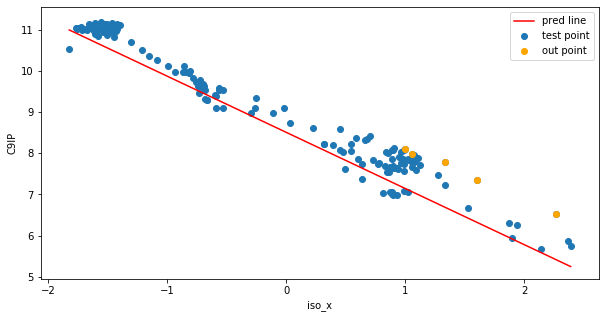

,R2,RMSE,mean_absolute_error
test_170,0.920433,0.444752,0.388696


In [26]:
plot_out(test_170_point)
plt.show()
d_out_score(test_170_point,'test_170')

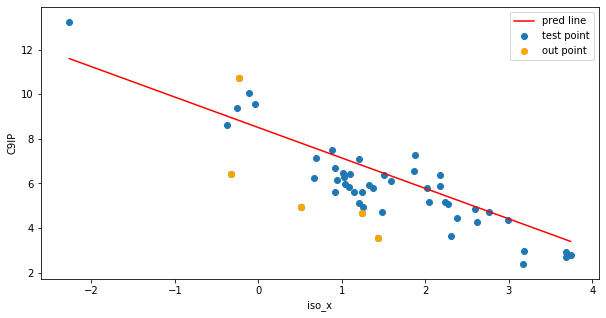

,R2,RMSE,mean_absolute_error
test_50,0.760219,0.990795,0.829699


In [27]:
plot_out(test_50_point)
plt.show()
d_out_score(test_50_point,'test_50')